# Deep Learning for Media 
#### MPATE-GE 2039 - DM-GY 9103 

---

## Final Project

##### Jingyue Huang (jh8522) & Lydia Morneault (lmm8719)


## Introduction
In this project, we are interested in exploring the relationships between chords and emotion expression of music. Thanks to the development of deep learning techniques in **Automatic Chord Recognition** and **Music Emotion Recognition** tasks, we could apply existing systems to estimate the time-varing chord progress and emotion values (valence and arousal), and then analyze their relationships. We hope that this analysis could further assist the improvement of chord recognition models by incorporating useful emotional information.

Our project is organized as follows: after training the chord recognition model (Part 1) and emotion recognition model (Part 2) to make predictions, we analyze the relationships between major-minor tonality and valence-arousal values (Part 3.1) as well as the relationship between chord recognition model errors and emotion (Part 3.2).

#### Dataset
The dataset we examined is `RWC Pop`, a part of the chord recognition dataset provided by Humphrey and Bello:

<blockquote>
Humphrey, E.J., & Bello, J.P. (2015). Four Timely Insights on Automatic Chord Estimation. International Society for Music Information Retrieval Conference.
</blockquote>

This dataset consists of 100 3-minute tracks from [RWC Music Database](https://staff.aist.go.jp/m.goto/RWC-MDB/), and provides time-varying symbolic representations of music in terms of chord labels, which allows for us to track chords over the duration of a track. The original dataset could be downloaded following the [instructions](https://mirdata.readthedocs.io/en/latest/source/mirdata.html#module-mirdata.datasets.rwc_popular). The dataset after preprocessing could be downloaded [here](https://drive.google.com/drive/folders/1rnZdzDm_MvzUzvR-MaT4qSJOhaE5qj7a?usp=sharing). The `rwc_popular` folder should be put into the same directory of this notebook. 

Considering that the emotion of a song changes over time, we split each audio into 10-second clips, and then predicted the valence and arousal labels for every clips to perform detailed analysis. Since the durations of chords are provided in the dataset, we used this information directly to match the chord labels with their corresponding emotional values.

In [1]:
# Fix the random seed for reproducibility
from numpy.random import seed
seed(42)
import tensorflow as tf
tf.keras.utils.set_random_seed(42)

In [27]:
from google.colab import drive
drive.mount('/content/drive/')

data_home = '/content/drive/MyDrive/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Part 1 - Chord Recognition

In this section, we will be using the [madmom](https://github.com/CPJKU/madmom) library to perform Deep Chroma Chord Recognition. This is a pre-trained model that uses chroma features to predict the chord labels for a given audio. 

In [ ]:
!pip install mirdata

In [ ]:
!pip install git+https://github.com/CPJKU/madmom.git

In [6]:
import numpy as np
import mirdata
import os
import madmom
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile as sf
import mir_eval

##### Load dataset

In [ ]:
dataset = mirdata.initialize('rwc_popular', data_home=data_home + 'rwc_popular')
#dataset.download()

# run this to test your code
example_track = dataset.track("RM-P048")
example_track

In [14]:
# collect tracks for which we have audio files
tracks = []
for i in dataset.track_ids:
 if os.path.exists(dataset.track(i).audio_path) :
   tracks.append(i)

In [17]:
print("Available tracks:", len(tracks))

Available tracks: 49


##### Chord Estimation

In [12]:
def estimate_chords(audio_path):
    """
    Compute chords using the Deep Chroma Chord Recogntion model, implemented in madmom.
    
    Parameters
    ----------
    audio_path : str
        Path to input audio file

    Returns
    -------
    chord_intervals : np.ndarray, shape=(n, 2)
        Chord intervals [start_time, end_time] in seconds
    chord_labels : list, shape=(n,)
        List of chord labels, e.g. ['A:maj', 'G:min', ...]

    """
    dcp = madmom.audio.chroma.DeepChromaProcessor()
    dccrp = madmom.features.chords.DeepChromaChordRecognitionProcessor()

    chroma = dcp(audio_path)
    chords = dccrp(chroma)

    # set up empty arrays
    chord_intervals = np.zeros((len(chords), 2))
    chord_labels = []

    # populate arrays with estimated chords and intervals
    for i in range(len(chords)):
      chord_intervals[i] = [chords[i][0],chords[i][1]]
      chord_labels.append(chords[i][2])

    return chord_intervals, chord_labels

In [72]:
### CHORD ESTIMATION LOOP ###

est_intervals = {}
est_labels = {}
ref_intervals = {}
ref_labels = {}
scores = []

for i in tracks:
  track = dataset.track(i)

  # estimate chords
  intervals, labels = estimate_chords(track.audio_path)
  est_intervals[i] = intervals
  est_labels[i] = labels

  # evaluate the accuracy of the predictions
  try:
    scores.append(mir_eval.chord.evaluate(ref_intervals=track.chords.intervals, ref_labels=track.chords.labels,
                                          est_intervals=intervals, est_labels=labels)['mirex'])
    ref_intervals[i] = track.chords.intervals
    ref_labels[i] = track.chords.labels
  
  except:
    print("Chord doesn't conform")

Chord doesn't conform
Chord doesn't conform
Chord doesn't conform
Chord doesn't conform


In [19]:
### WRITE RESULTS TO CSV ###
import csv

cols = ['ID', 'Est Chord','Est Interval Start', 'Est Interval End', 'True Chord', 'True Start', 'True End']
filename = "chord_results.csv"
rows = []

for i in est_intervals:
  track = dataset.track(i)
  for j in range(len(est_intervals[i])):
      try:
        rows.append({'ID':i, 'Est Chord':est_labels[i][j],'Est Interval Start':est_intervals[i][j][0], 'Est Interval End':est_intervals[i][j][1], \
                     'True Chord':track.chords.labels[j], 'True Start':track.chords.intervals[j][0], 'True End':track.chords.intervals[j][1]})
      except:
        rows.append({'ID':i, 'Est Chord':est_labels[i][j],'Est Interval Start':est_intervals[i][j][0], 'Est Interval End':est_intervals[i][j][1]})


In [20]:
with open(filename, 'w') as csvfile:
  writer = csv.DictWriter(csvfile, fieldnames=cols)
  writer.writeheader()
  writer.writerows(rows)

## Part 2 - Emotion Recognition

In this part, we performed transfer learning to recognize emotion labels of songs in `rwc_popupar` dataset. Specifically, we used `musicnn` to extract features on `emoMusic` dataset, and then trained a simple MLP model to predict emotion labels using the extracted features as input. After training, we could applied this architecture to recognize emotion labels given any songs.

#### 1. emoMusic
The emotion recognition dataset [emoMusic](https://dl.acm.org/doi/10.1145/2506364.2506365) consists of 744 songs collected from [Free Music Archive](http://freemusicarchive.org/) covering different genres of mainstream western music. Each sample contains 45-second music clips extracted randomly the full song, and is annotated using arousal (emotional intensity) and valence (positive versus negative emotion) levels on 9 point scale following the research:

<blockquote>
J. A. Russell. A circumplex model of affect. J. Personality
Social Psychology, 39:1161–1178, 1980.
</blockquote>

For raw data, [download](http://www.multimediaeval.org/mediaeval2013/emotion2013/index.html) the `clips_45sec.tar.gz` and `annotations.tar.gz` files from the MediaEval website, unzip and put it into the `emoMusic` folder. The dataset after preprocessing could be downloaded [here](https://drive.google.com/drive/folders/14LqsA8Etsc7SR1pSHuY5TXCOXJPffxiF?usp=sharing). The `emoMusic` folder should be put into the same directory of this notebook. We used R2 statistics and root-mean-square error for model evaluation as the original paper. 

#### 2. musicnn
The pre-trained model [musicnn](https://arxiv.org/pdf/1909.06654.pdf) is a musically motivated convolutional neural networks for music audio tagging. It provides the [API](https://github.com/jordipons/musicnn/blob/master/musicnn_example.ipynb) to extract the intermediate representations of models as features for transfer learning. We extracted the high-level representation `max_pool` in this project from the model trained on Million Song Dataset, since it considers both timbral and temporal information from different hierarchichal levels, and also allows for variable-lengths inputs.

After installing the package using `pip install musicnn`, 
one could extract features by running

```python
from musicnn.extractor import extractor
taggram, tags, features = extractor(file_name, model='MSD_musicnn', extract_features=True)
feature = features['max_pool']
```

However, since `musicnn` package requires the environment of `Python3.7`, a conflict may be caused when installing it directly in Colab. So we provides the extraced features in `npz` file for reproducibility. 

#### 3. MLP layer
Using the representations as input features, we predicted arousal and valence values separately with two models with the same architecture, i.e., a one-layer MLP with 512 hidden units.

### Transfer learning

In [ ]:
!pip install pydub

In [ ]:
# if not using pre-computing features, pip musicnn packages
# and uncomment this package import in utils.py

# !pip install musicnn

In [23]:
# Functions to load dataset, extract features and design models
# See the comment in utils.py for more details 
import utils as u

import numpy as np
import keras

In [31]:
config = {
    'dataset': 'emoMusic',
    'audio_folder': data_home + 'emoMusic/clips_45seconds/',
    'batch_size': 8,
    'features_type': 'musicnn',
    # Data: False to compute features or load pre-computed using e.g. 'training_data_emoMusic_musicnn_modify.npz'
    'load_training_data': 'training_data_emoMusic_musicnn.npz',  # False
    'load_evaluation_data': 'evaluation_data_emoMusic_musicnn.npz'  # False
}

##### Load dataset

In [28]:
# load training and test dataset
training_ids, training_valence, training_arousal, evaluation_ids, evaluation_valence, evaluation_arousal = u.load_emoMusic(data_home)

In [29]:
# split training and validation dataset
from sklearn.model_selection import train_test_split

track_ids = np.array([i for i in range(len(training_ids))])
train_ids, val_ids = train_test_split(track_ids, test_size=0.25, random_state=124)
test_ids = evaluation_ids

print('training examples: ' + str(len(train_ids)))
print('validation examples: ' + str(len(val_ids)))
print('test examples: ' + str(len(test_ids)))

training examples: 464
validation examples: 155
test examples: 125


##### Extract features

In [32]:
# extract musicnn features
if config['load_training_data']:
    print('Loading training features..')
    training_data = np.load(data_home + 'emoMusic/audio_representations/' + config['load_training_data'])
    training_features = training_data['X']
else:
    print('Extracting training features..')
    training_features = u.extract_features_emoMusic(training_ids, data_home, save_as='training_data_{}_{}'.format(config['dataset'], config['features_type']))
training_features = training_features.reshape((-1, 44, 753))
print(training_features.shape)

if config['load_evaluation_data']:
    print('Loading evaluation features..')
    evaluation_data = np.load(data_home + 'emoMusic/audio_representations/' + config['load_evaluation_data'])
    evaluation_features = evaluation_data['X']
else:
    print('Extracting evaluation features..')
    evaluation_features = u.extract_features_emoMusic(evaluation_ids, data_home, save_as='evaluation_data_{}_{}'.format(config['dataset'], config['features_type']))
evaluation_features = evaluation_features.reshape((-1, 44, 753))
print(evaluation_features.shape)

Loading training features..
(619, 44, 753)
Loading evaluation features..
(125, 44, 753)


In [33]:
# Create a TensorFlow dataset
input_shape = (1, 753)
batch_size = config['batch_size']

input_args_train_valence = [training_features[train_ids], training_valence[train_ids], True]
input_args_train_arousal = [training_features[train_ids], training_arousal[train_ids], True]
input_args_val_valence = [training_features[val_ids], training_valence[val_ids], True]
input_args_val_arousal = [training_features[val_ids], training_arousal[val_ids], True]
input_args_test_valence = [evaluation_features, evaluation_valence, False]
input_args_test_arousal = [evaluation_features, evaluation_arousal, False]

dataset_train_valence = u.create_dataset(u.data_generator, input_args_train_valence, input_shape, batch_size)
dataset_train_arousal = u.create_dataset(u.data_generator, input_args_train_arousal, input_shape, batch_size)
dataset_val_valence = u.create_dataset(u.data_generator, input_args_val_valence, input_shape, batch_size)
dataset_val_arousal = u.create_dataset(u.data_generator, input_args_val_arousal, input_shape, batch_size)
dataset_test_valence = u.create_dataset(u.data_generator, input_args_test_valence, input_shape, batch_size)
dataset_test_arousal = u.create_dataset(u.data_generator, input_args_test_arousal, input_shape, batch_size)

##### Build a MLP model to predict valence values

In [34]:
# Create a mlp model
model_valence = u.dnn_model(input_shape)

# Print model summary
model_valence.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 753)]          0         
                                                                 
 flatten (Flatten)           (None, 753)               0         
                                                                 
 dense (Dense)               (None, 512)               386048    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 386,561
Trainable params: 386,561
Non-trainable params: 0
_________________________________________________________________


In [35]:
# Define callbacks
callbacks = [
keras.callbacks.ModelCheckpoint(
    filepath="audio_convnet_valence.tf",
    save_best_only=True,
    monitor="val_loss")
]

# Train model
history = model_valence.fit(dataset_train_valence, 
                    validation_data=dataset_val_valence, 
                    epochs=300,
                    batch_size=batch_size, 
                    callbacks=callbacks)

Epoch 1/300
58/58 [==============================] - 7s 25ms/step - loss: 63.5122 - root_mean_squared_error: 7.9695 - val_loss: 10.8759 - val_root_mean_squared_error: 3.2979
Epoch 2/300
58/58 [==============================] - 1s 17ms/step - loss: 13.8113 - root_mean_squared_error: 3.7164 - val_loss: 1.9725 - val_root_mean_squared_error: 1.4045
Epoch 3/300
58/58 [==============================] - 0s 7ms/step - loss: 6.5644 - root_mean_squared_error: 2.5621 - val_loss: 4.1506 - val_root_mean_squared_error: 2.0373
Epoch 4/300
58/58 [==============================] - 1s 23ms/step - loss: 3.3095 - root_mean_squared_error: 1.8192 - val_loss: 1.5588 - val_root_mean_squared_error: 1.2485
Epoch 5/300
58/58 [==============================] - 1s 21ms/step - loss: 2.3871 - root_mean_squared_error: 1.5450 - val_loss: 1.3264 - val_root_mean_squared_error: 1.1517
Epoch 6/300
58/58 [==============================] - 1s 10ms/step - loss: 2.1345 - root_mean_squared_error: 1.4610 - val_loss: 1.3538 - va

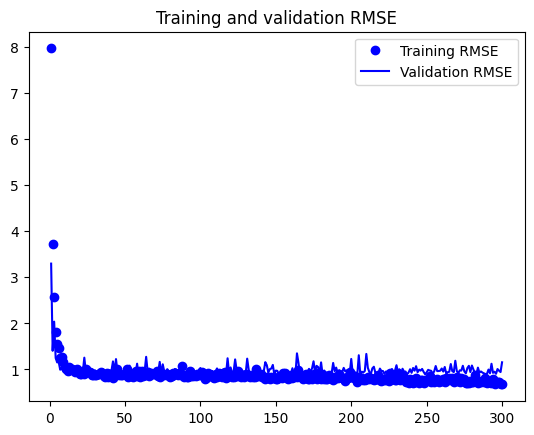

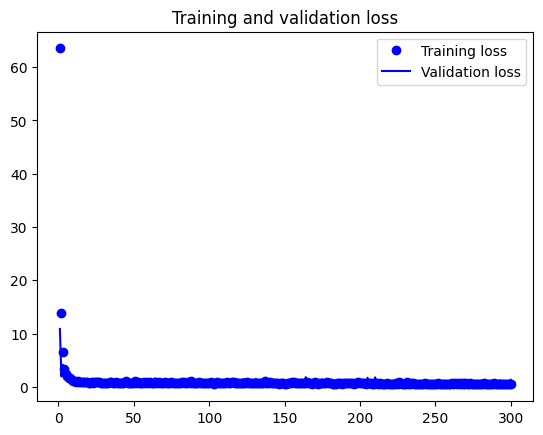

In [36]:
u.plot_loss(history)

In [37]:
from sklearn.metrics import r2_score

# Load the best checkpoint of the model
model_reloaded = keras.models.load_model("audio_convnet_valence.tf")

# Compute the r2 score
test_pred = model_reloaded.predict(dataset_test_valence)
print("R2 score of test: %.3f" % r2_score(evaluation_valence, test_pred))

16/16 [==============================] - 0s 7ms/step
R2 score of test: 0.414


##### Build a MLP model to predict arousal values

In [38]:
# Create a mlp model
model_arousal = u.dnn_model(input_shape)

# Print model summary
model_arousal.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 753)]          0         
                                                                 
 flatten_1 (Flatten)         (None, 753)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               386048    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 386,561
Trainable params: 386,561
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Define callbacks
callbacks = [
keras.callbacks.ModelCheckpoint(
    filepath="audio_convnet_arousal.tf",
    save_best_only=True,
    monitor="val_loss")
]

# Train the model
history = model_arousal.fit(dataset_train_arousal,
    validation_data=dataset_val_arousal,
    epochs=300,
    callbacks=callbacks,
)

Epoch 1/300
58/58 [==============================] - 3s 33ms/step - loss: 68.2716 - root_mean_squared_error: 8.2627 - val_loss: 3.3448 - val_root_mean_squared_error: 1.8289
Epoch 2/300
58/58 [==============================] - 2s 33ms/step - loss: 11.3432 - root_mean_squared_error: 3.3680 - val_loss: 2.5221 - val_root_mean_squared_error: 1.5881
Epoch 3/300
58/58 [==============================] - 1s 24ms/step - loss: 7.5910 - root_mean_squared_error: 2.7552 - val_loss: 2.0795 - val_root_mean_squared_error: 1.4420
Epoch 4/300
58/58 [==============================] - 1s 21ms/step - loss: 5.4819 - root_mean_squared_error: 2.3413 - val_loss: 1.3795 - val_root_mean_squared_error: 1.1745
Epoch 5/300
58/58 [==============================] - 1s 14ms/step - loss: 2.6168 - root_mean_squared_error: 1.6176 - val_loss: 2.9381 - val_root_mean_squared_error: 1.7141
Epoch 6/300
58/58 [==============================] - 2s 34ms/step - loss: 2.2217 - root_mean_squared_error: 1.4905 - val_loss: 1.1783 - va

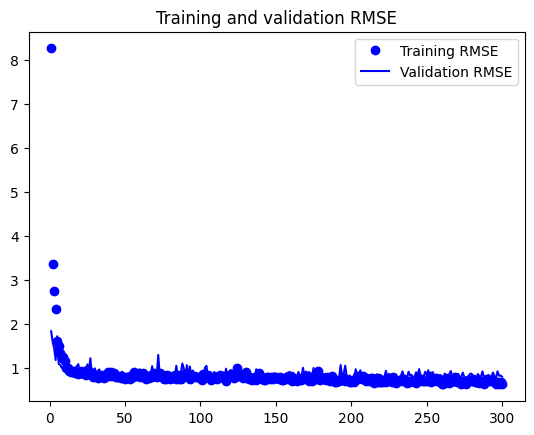

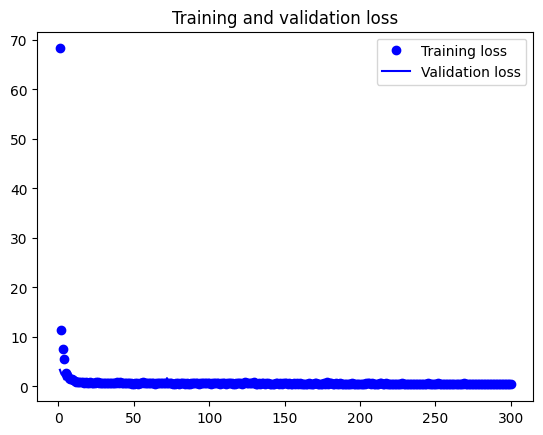

In [40]:
u.plot_loss(history)

In [41]:
# Load the best checkpoint of the model
model_reloaded = keras.models.load_model("audio_convnet_arousal.tf")

# Compute the r2 score
test_pred = model_reloaded.predict(dataset_test_arousal)
print("R2 score of test: %.3f" % r2_score(evaluation_arousal, test_pred))

16/16 [==============================] - 0s 6ms/step
R2 score of test: 0.685


**Comment**: In [JukeMIR](https://github.com/p-lambda/jukemir), the authors used the features extracted from `musicnn` for downstream task emotion recognition on dataset `emoMusic` as baseline. Our transfer learning model follows same settings except that we only used `max_pool` while JukeMIR concatenated together the `max_pool` and `mean_pool` features. Our valence and arousal results are close to the reported R2 scores of 0.466 and 0.703 respectively. 

### Emotion Recognition on rwc_popular

##### Load dataset and extract features

In [42]:
# Load rwc_popular dataset
clip_paths = u.load_rwc_popular(data_home, save_clip=False)  # set save_clip=True when running first time
print('Number of 10-second clips: ', len(clip_paths))

Number of tracks:  49
Number of 10-second clips:  1173


In [43]:
# Whether to load pre-computed features
load_rwc_features = True

In [44]:
# Extract features
if load_rwc_features:
  print('Loading features..')
  rwc_features = np.load(data_home + 'rwc_popular/audio_representations/rwc_popular_musicnn.npz')['X']
else:
  rwc_features = u.extract_features_rwc(clip_paths, data_home, save_as='rwc_popular_musicnn.npz')
print(rwc_features.shape)

Loading features..
(1173, 753)


In [45]:
# Create a TensorFlow dataset
input_shape = (1, 753)
batch_size = config['batch_size']

input_args = [rwc_features]
rwc_dataset = u.create_dataset_rwc(u.data_generator_rwc, input_args, input_shape, batch_size)

##### Emotion Recognition

In [46]:
# Load prediction models
valence_model = keras.models.load_model("audio_convnet_valence.tf")
arousal_model = keras.models.load_model("audio_convnet_arousal.tf")

# Prediction emotion values
valence_pred = valence_model.predict(rwc_dataset)
arousal_pred = arousal_model.predict(rwc_dataset)

147/147 [==============================] - 0s 2ms/step


In [47]:
# Write the results into csv file
header = ['clip', 'valence', 'arousal']
emotion_values = [(clip_paths[i], valence_pred[i][0], arousal_pred[i][0]) for i in range(len(clip_paths))]

with open('rwc_emotion.csv', 'w', encoding='utf-8') as file_obj:
    writer = csv.writer(file_obj)
    writer.writerow(header)
    for p in emotion_values:
        writer.writerow(p)

##### Listen to the examples

In [48]:
import IPython

# Example 1 - High Arousal, High Valence
id = 13
clip_path = data_home + 'rwc_popular/clips_10seconds/' + clip_paths[id]
print("Valence: %.3f, Arousal: %.3f" % (valence_pred[id][0], arousal_pred[id][0]))
IPython.display.Audio(filename=clip_path)

Valence: 5.751, Arousal: 8.455


In [49]:
# Example 2 - Low Arousal, Low Valence
id = 63
clip_path = data_home + 'rwc_popular/clips_10seconds/' + clip_paths[id]
print("Valence: %.3f, Arousal: %.3f" % (valence_pred[id][0], arousal_pred[id][0]))
IPython.display.Audio(filename=clip_path)

Valence: 3.990, Arousal: 2.729


In [50]:
# Example 3 - Next cilp of example 2
id = 64
clip_path = data_home + 'rwc_popular/clips_10seconds/' + clip_paths[id]
print("Valence: %.3f, Arousal: %.3f" % (valence_pred[id][0], arousal_pred[id][0]))
IPython.display.Audio(filename=clip_path)

Valence: 5.979, Arousal: 4.845


## Part 3 - Analysis

### Part 3.1 - Relationships between major-minor tonality and valence-arousal values

In this part, we computed the number of major-minor tonality of both reference and estimation labels in the context of high or low valence/arousal values. We used the average valence/arousal values as the middle point to determine high or low valence/arousal. 

In [57]:
import pandas
import math
import matplotlib.pyplot as plt

In [79]:
# read CSVs into lists
emotions = {}
valences = []
arousals = []

with open('rwc_emotion.csv', mode ='r')as file:
   
  # reading the CSV file
  csvFile = csv.reader(file)

  header = True
  for line in csvFile:
    if header:
      header = False
      continue
    emotions[line[0]] = (float(line[1]), float(line[2]))
    valences.append(float(line[1]))
    arousals.append(float(line[2]))

# get median valence and arousal
mid_val = np.median(np.array(valences))
mid_aro = np.median(np.array(arousals))
print('Median valence:', mid_val)
print('Median arousal:', mid_aro)

Median valence: 6.0969872
Median arousal: 6.255621


In [80]:
order = ['C:maj', 'C#:maj', 'D:maj', 'D#:maj', 
         'E:maj', 'F:maj', 'F#:maj', 'G:maj', 
         'G#:maj', 'A:maj', 'A#:maj', 'B:maj', 
         'C:min', 'C#:min', 'D:min', 'D#:min', 
         'E:min', 'F:min', 'F#:min', 'G:min', 
         'G#:min', 'A:min', 'A#:min', 'B:min']

##### Estimation labels

In [82]:
valence_cts = {}
arousal_cts = {}

for trk in est_intervals:
  for inv in range(len(est_intervals[trk])):
    end = est_intervals[trk][inv][1]

    # creates string to find the correct 10-second split in the audio data
    idx = round(end / 10)
    clip_name = trk + "_" + str(idx) + '.wav'
    if clip_name not in emotions:
      continue

    if est_labels[trk][inv] not in valence_cts:
      valence_cts[est_labels[trk][inv]] = [0,0]

    # add chord valence
    if float(emotions[clip_name][0]) >= mid_val:
      valence_cts[est_labels[trk][inv]][0] = valence_cts[est_labels[trk][inv]][0] + 1
    else:
      valence_cts[est_labels[trk][inv]][1] = valence_cts[est_labels[trk][inv]][1] + 1

    if est_labels[trk][inv] not in arousal_cts:
      arousal_cts[est_labels[trk][inv]] = [0,0]
      
    # add chord arousal
    if float(emotions[clip_name][1]) >= mid_aro:
      arousal_cts[est_labels[trk][inv]][0] = arousal_cts[est_labels[trk][inv]][0] + 1
    else:
      arousal_cts[est_labels[trk][inv]][1] = arousal_cts[est_labels[trk][inv]][1] + 1

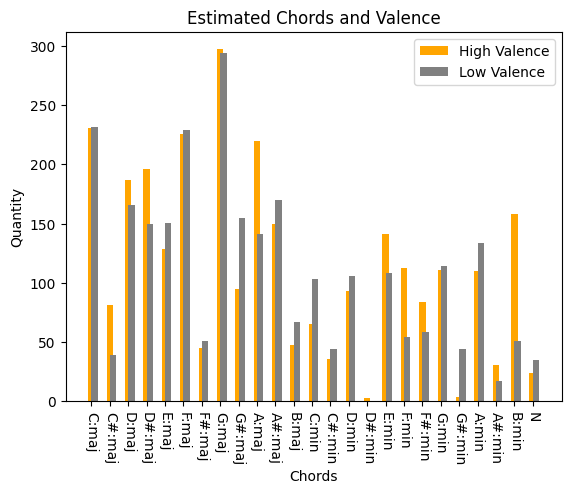

In [83]:
### PLOTTING ESTIMATED VALENCE ###

# extract the keys and values from both dictionaries
keys = order + ['N']
values1 = [valence_cts[keys[i]][0] for i in range(len(keys))]
values2 = [valence_cts[keys[i]][1] for i in range(len(keys))]

# set the width of each bar
bar_width = 0.35

# plot the bars side by side
plt.bar(keys, values1, width=bar_width, label='High Valence', color='orange')
plt.bar(keys, values2, width=bar_width, label='Low Valence', align='edge', color='gray')

# set the axis labels and title
plt.xlabel('Chords')
plt.ylabel('Quantity')
plt.title('Estimated Chords and Valence')
plt.xticks(rotation=270)

# set the legend
plt.legend()

# save the plot
plt.savefig('estimated_valence.png')

# show the plot
plt.show()

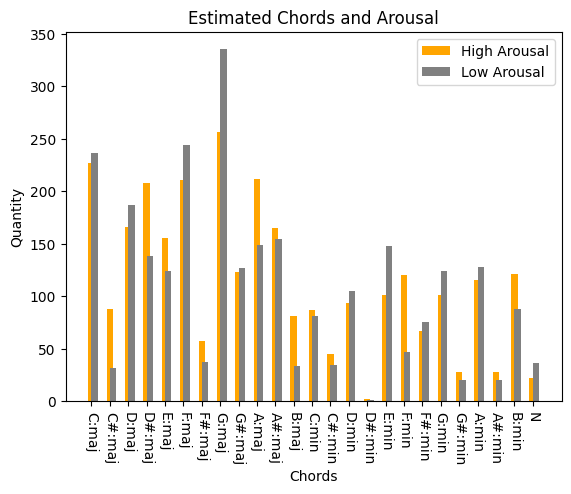

In [84]:
### PLOTTING ESTIMATED AROUSAL ###

# extract the keys and values from both dictionaries
keys = order + ['N']
values1 = [arousal_cts[keys[i]][0] for i in range(len(keys))]
values2 = [arousal_cts[keys[i]][1] for i in range(len(keys))]

# set the width of each bar
bar_width = 0.35

# plot the bars side by side
plt.bar(keys, values1, width=bar_width, label='High Arousal', color='orange')
plt.bar(keys, values2, width=bar_width, label='Low Arousal', align='edge', color='grey')

# set the axis labels and title
plt.xlabel('Chords')
plt.ylabel('Quantity')
plt.title('Estimated Chords and Arousal')
plt.xticks(rotation=270)

# set the legend
plt.legend()

# save the plot
plt.savefig('estimated_arousal.png')

# show the plot
plt.show()

##### Reference labels

In [85]:
import re

valence_cts = {}
arousal_cts = {}
chords = list()

chord_dict = {'Ab:min': 'G#:min', 'Ab:maj': 'G#:maj', 
              'Bb:min': 'A#:min', 'Bb:maj': 'A#:maj', 
              'Db:min': 'C#:min', 'Db:maj': 'C#:maj', 
              'Eb:min': 'D#:min', 'Eb:maj': 'D#:maj',
              'Gb:min': 'F#:min', 'Gb:maj': 'F#:maj', 
              'Cb:maj': 'B:maj'}

for trk in ref_intervals:
  for inv in range(len(ref_intervals[trk])):
    end = ref_intervals[trk][inv][1]

    # finds relevant split
    idx = round(end / 10)
    clip_name = trk + "_" + str(idx) + '.wav'
    if clip_name not in emotions:
      continue

    # Simplify true label and ignore non-major/minor ones
    chords.append(ref_labels[trk][inv])
    chord_label = ref_labels[trk][inv]
    if 'min' in chord_label:
      simple_label = re.findall('[\w+#]+:min', chord_label)[0]
    elif 'maj' in chord_label:
      simple_label = re.findall('[\w+#]+:maj', chord_label)[0]
    else:
      continue
    if simple_label in chord_dict:
      simple_label = chord_dict[simple_label]

    if simple_label not in valence_cts:
      valence_cts[simple_label] = [0,0]
    # add chord valence
    if float(emotions[clip_name][0]) >= mid_val:
      valence_cts[simple_label][0] = valence_cts[simple_label][0] + 1
    else:
      valence_cts[simple_label][1] = valence_cts[simple_label][1] + 1

    if simple_label not in arousal_cts:
      arousal_cts[simple_label] = [0,0]
    # add chord arousal
    if float(emotions[clip_name][1]) >= mid_aro:
      arousal_cts[simple_label][0] = arousal_cts[simple_label][0] + 1
    else:
      arousal_cts[simple_label][1] = arousal_cts[simple_label][1] + 1

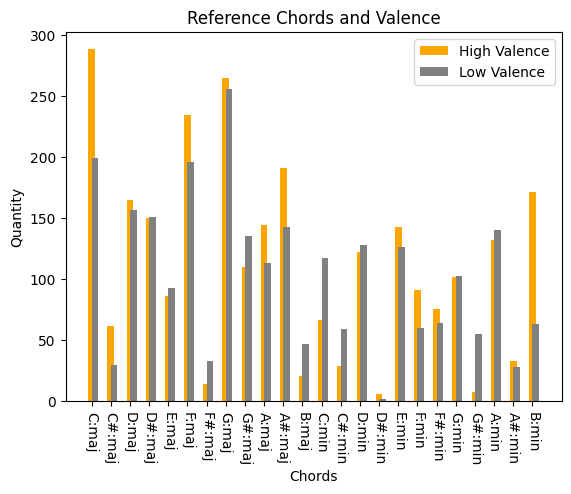

In [91]:
### PLOTTING TRUE VALENCE ###

# extract the keys and values from both dictionaries
keys = order
values1 = [valence_cts[order[i]][0] for i in range(len(order))]
values2 = [valence_cts[order[i]][1] for i in range(len(order))]

# set the width of each bar
bar_width = 0.35

# plot the bars side by side
plt.bar(keys, values1, width=bar_width, label='High Valence', color='orange')
plt.bar(keys, values2, width=bar_width, label='Low Valence', align='edge', color='gray')

# set the axis labels and title
plt.xlabel('Chords')
plt.ylabel('Quantity')
plt.title('Reference Chords and Valence')
plt.xticks(rotation=270)

# set the legend
plt.legend()

# save the plot
plt.savefig('reference_valence.png')

# show the plot
plt.show()

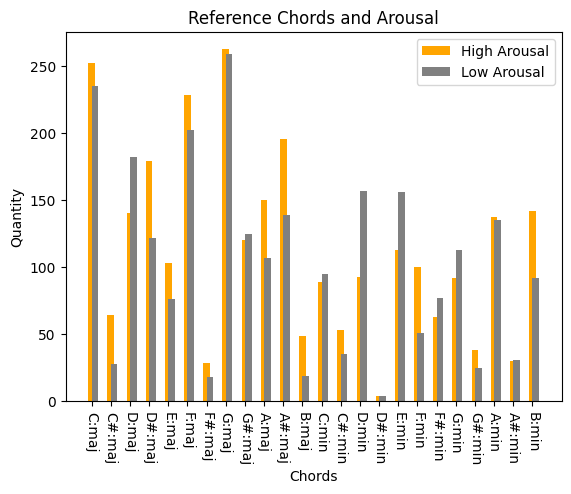

In [92]:
### PLOTTING TRUE AROUSAL ###

# extract the keys and values from both dictionaries
keys = order
values1 = [arousal_cts[order[i]][0] for i in range(len(order))]
values2 = [arousal_cts[order[i]][1] for i in range(len(order))]

# set the width of each bar
bar_width = 0.35

# plot the bars side by side
plt.bar(keys, values1, width=bar_width, label='High Arousal', color='orange')
plt.bar(keys, values2, width=bar_width, label='Low Arousal', align='edge', color='grey')

# set the axis labels and title
plt.xlabel('Chords')
plt.ylabel('Quantity')
plt.title('Reference Chords and Arousal')
plt.xticks(rotation=270)

# set the legend
plt.legend()

# save the plot
plt.savefig('reference_arousal.png')

# show the plot
plt.show()

**Comment**: With the reference labels, it can be observed that major tonality occurs more frequently in emotions with high valence or high arousal, such as C:maj, F:maj, and G:maj, while minor tonality is associated with emotions having low valence or low arousal, such as D:min, E:min, and G:min. This pattern is more distinct in the arousal plot as compared to the valence plot. However, with the estimated labels, several chords have a similar frequency across different emotions, and most major chords appear more frequently in emotions with low valence or low arousal, which contradicts the findings in psychology. Therefore, incorporating emotion information may be useful in chord recognition by assigning varying weights to the prediction of major/minor tonality.

### Part 3.2 - Relationships between chord recognition model errors and emotion
In this part, we examined the relationships between the prediction errors from the chord recognition model and predicted emotion labels. We used the functions provided in `mir_eval` to merge the intervals of reference and estimation intervals, and then compared the reference and estimation chord labels in the context of four kinds of emotions: High Valence High Arousal (HVHA), High Valence Low Arousal (HVLA), Low Valence High Arousal (LVHA), Low Valence Low Arousal (LVLA). 

For simplification, we only considered the major-minor moods and qualities outside major/minor are ignored. Specifically, we computed four kinds of errors:
* W_maj2maj: both reference and estimation labels are major chords but the estimation root is wrong
* W_maj2min: the reference label is major but the estimation label is minor
* W_min2maj: the reference label is minor but the estimation label is major
* W_min2min: both reference and estimation labels are minor chords but the estimation root is wrong

In [88]:
from mir_eval import util

# Keep the number of errors
error_analysis = {'HVHA': {'R':0, 'W_maj2maj':0, 'W_maj2min': 0, 'W_min2maj': 0, 'W_min2min': 0}, 
                  'HVLA': {'R':0, 'W_maj2maj':0, 'W_maj2min': 0, 'W_min2maj': 0, 'W_min2min': 0}, 
                  'LVHA': {'R':0, 'W_maj2maj':0, 'W_maj2min': 0, 'W_min2maj': 0, 'W_min2min': 0}, 
                  'LVLA': {'R':0, 'W_maj2maj':0, 'W_maj2min': 0, 'W_min2maj': 0, 'W_min2min': 0}}

# Track errors for each song
for trk in est_labels:
  if trk not in ref_labels:
    continue
  est_label = est_labels[trk]
  ref_label = ref_labels[trk]
  est_interval = est_intervals[trk]
  ref_interval = ref_intervals[trk]

  # Merge the intervals for better match
  est_interval, est_label = util.adjust_intervals(
      est_interval, est_label, ref_interval.min(), ref_interval.max(), "N", "N")
  intervals, ref_label, est_label = util.merge_labeled_intervals(
        ref_interval, ref_label, est_interval, est_label)

  # Compare each pair of reference and estimation labels
  for inv in range(len(intervals)):
    end = intervals[inv][1]

    # Find relevant clip 
    idx = round(end / 10)
    clip_name = trk + "_" + str(idx) + '.wav'
    if clip_name not in emotions:
      continue

    # Determine emotion class
    valence, arousal = emotions[clip_name]
    if valence >= avg_val:
      if arousal >= avg_aro:
        emotion_label = 'HVHA'
      else:
        emotion_label = 'HVLA'
    else:
      if arousal >= avg_aro:
        emotion_label = 'LVHA'
      else:
        emotion_label = 'LVLA'

    # Find true and predicted labels
    pred_chord = est_label[inv]
    true_chord = ref_label[inv]

    # Simplify true label and ignore non-major/minor ones
    if 'min' in true_chord:
      true_chord = re.findall('[\w+#]+:min', true_chord)[0]
    elif 'maj' in true_chord:
      true_chord = re.findall('[\w+#]+:maj', true_chord)[0]
    else:
      continue
    if true_chord in chord_dict:
        true_chord = chord_dict[true_chord]
  
    # Update the prediction error
    if true_chord == pred_chord:
      error_analysis[emotion_label]['R'] += 1
    else:
      if 'maj' in pred_chord:
        if 'maj' in true_chord:
          error_analysis[emotion_label]['W_maj2maj'] += 1
        else:
          error_analysis[emotion_label]['W_min2maj'] += 1
      else:
        if 'maj' in true_chord:
          error_analysis[emotion_label]['W_maj2min'] += 1
        else:
          error_analysis[emotion_label]['W_min2min'] += 1

In [89]:
for emo in error_analysis:
  print('Emotion:', emo)
  for k, v in error_analysis[emo].items():
    print(k, v)
  print()

Emotion: HVHA
R 1490
W_maj2maj 817
W_maj2min 294
W_min2maj 601
W_min2min 185

Emotion: HVLA
R 753
W_maj2maj 359
W_maj2min 149
W_min2maj 272
W_min2min 94

Emotion: LVHA
R 761
W_maj2maj 394
W_maj2min 186
W_min2maj 299
W_min2min 72

Emotion: LVLA
R 1381
W_maj2maj 665
W_maj2min 250
W_min2maj 591
W_min2min 215



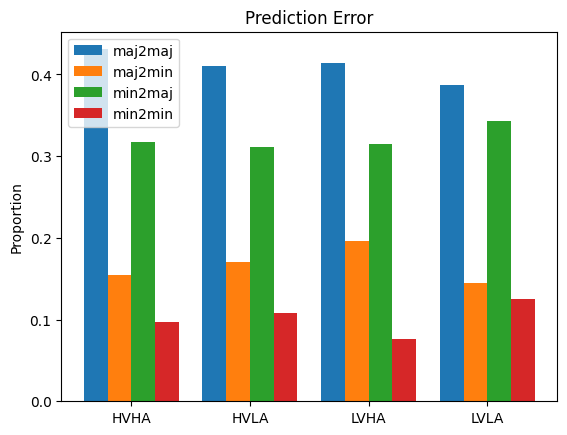

In [90]:
# make the bar plot
w1 = list()
w2 = list()
w3 = list()
w4 = list()
for i in error_analysis:
  total_error = error_analysis[i]['W_maj2maj'] + error_analysis[i]['W_maj2min'] + error_analysis[i]['W_min2maj'] + error_analysis[i]['W_min2min']
  w1.append(error_analysis[i]['W_maj2maj'] / total_error)
  w2.append(error_analysis[i]['W_maj2min'] / total_error)
  w3.append(error_analysis[i]['W_min2maj'] / total_error)
  w4.append(error_analysis[i]['W_min2min'] / total_error)
  
# set the width of each bar
width = 0.8
bar_width = width/4
ind = np.arange(0,4)

# plot the bars side by side
plt.bar(ind-1.5 * bar_width, w1, width=bar_width, label='maj2maj')
plt.bar(ind-0.5 * bar_width, w2, width=bar_width, label='maj2min')
plt.bar(ind+0.5 * bar_width, w3, width=bar_width, label='min2maj')
plt.bar(ind+1.5 * bar_width, w4, width=bar_width, label='min2min')

# set the axis labels and title
plt.xticks(ind, error_analysis.keys())
plt.ylabel("Proportion")
plt.title("Prediction Error")

# set the legend
plt.legend()

# save the plot
plt.savefig('prediction_error.png')

# show the plot
plt.show()

**Comment**: Based on the bar plot above, the main source of error in recognizing emotions is the misclassification of major chords. Additionally, the `LVHA` class has the highest proportion of `maj2min errors` while the `LVLA` class has the lowest proportion, suggesting the importance of incorporating high arousal information to reduce the frequency of misclassified minor chords. On the other hand, the highest proportion of `min2maj` errors occurs in the `LVLA` class, while the lowest proportion occurs in `LVHA`, implying the potential impact of low arousal information on reducing the misclassification of major chords. However, the results suggest that valence information may be less useful in improving chord recognition accuracy, which is consistent with the findings presented above.

Due to the time limitation, we only analyzed the relationships between major/minor chords and emotions in this project. More detailed analysis could be made to examine the relationships of complex chord and emotional context, and then further assist the development of fine-grained chord estimation.